In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#importing necessary library

import matplotlib.pyplot as plt
import os,re
from tqdm import tqdm
from sklearn.utils import class_weight
import torch
from transformers import BertTokenizer, BertModel
from torch.nn.parallel import DataParallel

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-data/y_spam_data.npy
/kaggle/input/email-spam-data/ham_data.npy
/kaggle/input/email-spam-data/y_ham_data.npy
/kaggle/input/email-spam-data/spam_data.npy


## RNN-GRU MODEL  
- Obtained 0.99 AUC 😂 after downstreaming from BERT-LARGE MODEL
- Used class weights to balance the loss fuction instead of under-sampling, over sampling etc etc
- with just 128 GRU units 0.99 AUC is obtained
- for more results read below.
- Suject of EMAIL & Body is concatenated which is fed into BERT-large Model which uses max pooling for anomaly detection


In [99]:
X=np.vstack((np.load("/kaggle/input/email-spam-data/ham_data.npy"),np.load("/kaggle/input/email-spam-data/spam_data.npy")))
y=np.concatenate((np.load("/kaggle/input/email-spam-data/y_ham_data.npy"), np.load("/kaggle/input/email-spam-data/y_spam_data.npy")), axis=0)

In [100]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [101]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.ravel())


In [102]:
X_train.shape

(6864, 1024)

In [103]:
from keras.models import Sequential
from keras.layers import GRU, Dense,LSTM
import tensorflow as tf
tf.config.run_functions_eagerly(True)

input_shape = (1, 1024)
model = Sequential()
model.add(GRU(128, input_shape=input_shape))
# model.add(LSTM(64))
# model.add(LSTM(16))

model.add(Dense(1, activation='sigmoid'))



model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 128)               443136    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 443,265
Trainable params: 443,265
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [105]:
X_train.shape

(6864, 1024)

In [106]:
X_train_3d = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [107]:
X_train_3d.shape

(6864, 1, 1024)

In [108]:
history=model.fit(X_train_3d, y_train, batch_size=32, epochs=15, validation_split=0.2,class_weight = {0: class_weights[0],1:class_weights[1]})


Epoch 1/15
  1/172 [..............................] - ETA: 12s - loss: 0.7211 - accuracy: 0.6250

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


172/172 [==============================] - 9s 55ms/step - loss: 0.6978 - accuracy: 0.5875 - val_loss: 0.6026 - val_accuracy: 0.8252
Epoch 2/15
172/172 [==============================] - 9s 53ms/step - loss: 0.5528 - accuracy: 0.7714 - val_loss: 0.3553 - val_accuracy: 0.9432
Epoch 3/15
172/172 [==============================] - 10s 57ms/step - loss: 0.3618 - accuracy: 0.8742 - val_loss: 0.3956 - val_accuracy: 0.8237
Epoch 4/15
172/172 [==============================] - 9s 53ms/step - loss: 0.2499 - accuracy: 0.9239 - val_loss: 0.2528 - val_accuracy: 0.9148
Epoch 5/15
172/172 [==============================] - 9s 55ms/step - loss: 0.2063 - accuracy: 0.9275 - val_loss: 0.1407 - val_accuracy: 0.9563
Epoch 6/15
172/172 [==============================] - 9s 53ms/step - loss: 0.1826 - accuracy: 0.9359 - val_loss: 0.1411 - val_accuracy: 0.9534
Epoch 7/15
172/172 [==============================] - 10s 59ms/step - loss: 0.1439 - accuracy: 0.9486 - val_loss: 0.1152 - val_accuracy: 0.9621
Epoch 8/

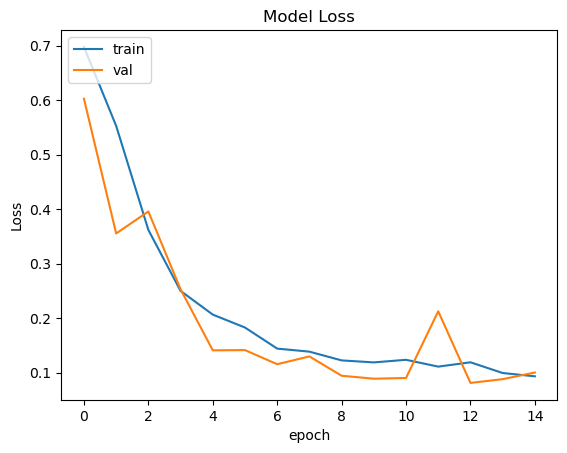

In [109]:
history.history.keys()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [114]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.metrics import RocCurveDisplay
y_pred=model.predict(np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])))


10/54 [====>.........................] - ETA: 0s

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


54/54 [==============================] - 1s 12ms/step


In [117]:
preds=np.where(y_pred> 0.50, 1, 0)


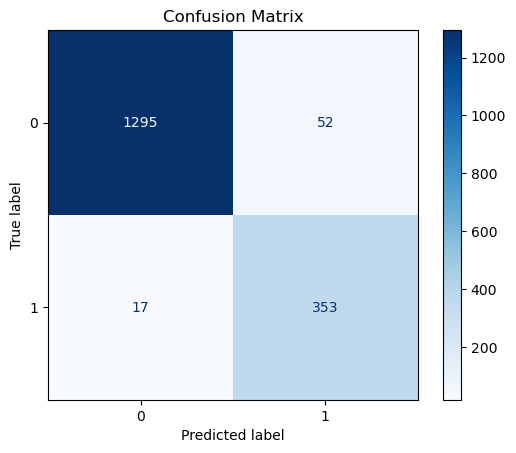

Text(0.5, 1.0, 'ROC CURVE')

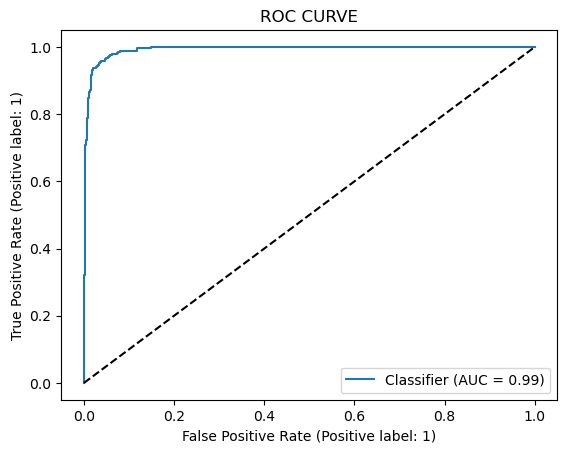

In [118]:
cm=confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#printing ROC curve
RocCurveDisplay.from_predictions(
    y_test,
    y_pred
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("ROC CURVE")


In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      1347
         1.0       0.87      0.95      0.91       370

    accuracy                           0.96      1717
   macro avg       0.93      0.96      0.94      1717
weighted avg       0.96      0.96      0.96      1717

